In [29]:
dependencies = ["mesa", "numpy", "pandas"]

In [30]:
import importlib
import subprocess
import sys

def install_and_import(package):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed")
    except ImportError:
        print(f"{package} is not installed, installing now...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} has been installed")

for package in dependencies:
    install_and_import(package)

mesa is already installed
numpy is already installed
pandas is already installed


In [31]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que exista más de un agente por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random
import heapq
MAXVAL = 10000

In [204]:
def generate_test_grids(width = 10, height = 10, wall_percentage=0.2, max_garbage_per_cell=8, min_empty_cells = 0.5):
    test_grid = np.random.choice(max_garbage_per_cell,width*height).astype("str")
    min_empty_cells = int(round(min_empty_cells * (width * height)))
    wall_qty = int(round(wall_percentage * (width * height)))
    for i in range(wall_qty): test_grid[i] = "X"
    for j in range(min_empty_cells): test_grid[j] = "0"
    test_grid[0] = "P"
    np.random.shuffle(test_grid)
    return test_grid.reshape(width,height)

generate_test_grids()

array([['4', '6', '2', '0', '0', '0', '0', '6', '0', '0'],
       ['0', '1', '0', '0', '5', '0', '4', '0', '7', '5'],
       ['1', '1', '0', '2', '0', '0', '0', '7', '0', '0'],
       ['5', '0', '0', '2', '2', '2', '0', '0', '4', '0'],
       ['1', '0', '0', 'P', '0', '0', '1', '0', '0', '6'],
       ['7', '0', '0', '3', '0', '0', '0', '7', '0', '7'],
       ['4', '0', '6', '0', '0', '5', '7', '1', '7', '0'],
       ['0', '4', '4', '5', '0', '7', '0', '0', '1', '3'],
       ['1', '0', '1', '0', '0', '0', '0', '0', '5', '2'],
       ['0', '0', '7', '6', '0', '0', '0', '0', '1', '0']], dtype='<U21')

In [32]:
%%writefile grid.txt
6 5
0 4 X 6 0
6 X 0 X 4
0 X 7 X 0
5 0 0 X 8
0 0 X 0 0
0 0 0 0 P

Overwriting grid.txt


In [33]:
file_name = 'grid.txt'

def leer_grid(nombre_archivo):
  with open(nombre_archivo, 'r') as archivo:
    lineas = archivo.readlines()
    n, m = map(int, lineas[0].split())
    oficina = []
    papelera_pos = None
    for i in range(1, n + 1):
      fila = lineas[i].strip().split()
      oficina.append(fila)
      if 'P' in fila:
        papelera_pos = (i - 1, fila.index('P'))
    return oficina, papelera_pos, n, m

# Llama a la función para leer el archivo
oficina, papelera_pos, alto, ancho = leer_grid(file_name)
print(oficina)
print(papelera_pos)

[['0', '4', 'X', '6', '0'], ['6', 'X', '0', 'X', '4'], ['0', 'X', '7', 'X', '0'], ['5', '0', '0', 'X', '8'], ['0', '0', 'X', '0', '0'], ['0', '0', '0', '0', 'P']]
(5, 4)


In [34]:
class Basura(Agent):
    def __init__(self, unique_id, model, cantidad):
        super().__init__(unique_id, model)
        self.qty = cantidad
        self.agents_on_top = None

    def notify(self, AgenteRobot):
        AgenteRobot.clean()

    def step(self):
        self.agents_on_top = model.grid.get_cell_list_contents([self.pos])

        if (self.agents_on_top):
            for agent in self.agents_on_top:
                if isinstance(agent, AgenteRobot):
                    self.notify(agent)


In [35]:
class Obstaculo(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

In [36]:
class Papelera(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.position = self.pos

In [37]:
def NewShuffle(arr):
  mutable_arr = [list(item) for item in arr]
  n = len(mutable_arr)
  for i in range(n - 1, 0, -1):
    j = np.random.randint(0, i)
    mutable_arr[i], mutable_arr[j] = mutable_arr[j], mutable_arr[i]

  # Convertir de nuevo a lista de tuplas
  return [tuple(item) for item in mutable_arr]

In [38]:
def reconstruct_path(came_from, current):
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        if current:
            total_path.append(current)
    total_path.reverse()
    return total_path

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search(grid, start, goal):
    open_list = []
    heapq.heappush(open_list, (0, start))
    came_from = {start: None}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}
    while open_list:
      _, current = heapq.heappop(open_list)
      if current == goal:
        return reconstruct_path(came_from, current)
      neighbors = grid.get_neighborhood(current, moore=True, include_center=False)
      for neighbor in neighbors:
        if grid.out_of_bounds(neighbor):
          continue
        cell_contents = grid.get_cell_list_contents(neighbor)
        if any(isinstance(obj, Obstaculo) for obj in cell_contents):
          continue
        tentative_g_score = g_score[current] + 1
        if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
          came_from[neighbor] = current
          g_score[neighbor] = tentative_g_score
          f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
          heapq.heappush(open_list, (f_score[neighbor], neighbor))

    return None  # No se encontró ningún camino

In [39]:
#Nombre: AgenteRobot
#Parametros: Ninguno.
#Return: Nada
#Se encarga de servir como base para crear agentes de tipo aspiradora
class AgenteRobot(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.capacity = 5
    self.carrying = 0
    self.papeleraPos = papelera_pos
    self.returning = False
    self.path_to_papelera = []

  def clean(self):
    cell_contents = self.model.grid.get_cell_list_contents([self.pos])
    trash_in_cell = [obj for obj in cell_contents if isinstance(obj, Basura)]
    trash_count = len(trash_in_cell)
    if trash_count > 0:
      if trash_count <= (self.capacity - self.carrying):
        to_collect = trash_in_cell
      else:
        to_collect = trash_in_cell[:self.capacity - self.carrying]
      for trash in to_collect:
        self.model.grid.remove_agent(trash)
        self.carrying += 1
        print(f"Robot {self.unique_id} recogió basura en {self.pos}. Almacenamiento: {self.carrying}/{self.capacity}")

  def empty(self):
    self.carrying = 0
    self.returning = False
    print(f"Robot {self.unique_id} vació su contenido en la papelera.")

  def find_path_to_papelera(self):
    self.path_to_papelera = a_star_search(self.model.grid, self.pos, self.papeleraPos)
    if self.path_to_papelera:
      self.path_to_papelera.pop(0)  # Remove the current position

  def move(self):
    if self.returning and self.path_to_papelera:
      new_position = self.path_to_papelera.pop(0)
      self.model.grid.move_agent(self, new_position)
      if new_position == self.papeleraPos:
        self.empty()
    else:
      options=self.model.grid.get_neighborhood(self.pos,moore = True, include_center=False)
      valid_moves = []
      for pos in options:
        cell_contents = self.model.grid.get_cell_list_contents(pos)
        if not any(isinstance(obj, (Obstaculo, AgenteRobot)) for obj in cell_contents):
          valid_moves.append(pos)

      if valid_moves:
        new_position = random.choice(valid_moves)
        self.model.grid.move_agent(self, new_position)

  def step(self):
    if self.carrying >= self.capacity:
      if not self.returning:
        self.returning = True
        self.find_path_to_papelera()
    if not self.returning:
      self.clean()  # Collect trash in the current cell
    self.move()   # Move to a new cell or towards the papelera

In [40]:
#Nombre: getGrid
#Parametros: un model.
#Return: Nada
#Se encarga de crear una representación visual del estado actual de la cuadrícula en el modelo
def getGrid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            if not model.grid.is_cell_empty((x, y)):
                contents = model.grid.get_cell_list_contents((x, y))
                if any(isinstance(agent, Basura) for agent in contents):
                    grid[x][y] = 2  # Asignar 1 si hay una basura en la celda
                elif any(isinstance(agent, AgenteRobot) for agent in contents):
                    grid[x][y] = 4  # Asignar 2 si hay un agente robot en la celda
                elif any(isinstance(agent, Obstaculo) for agent in contents):
                    grid[x][y] = 1  # Asignar 3 si hay un agente obstaculo en la celda
                elif any(isinstance(agent, Papelera) for agent in contents):
                    grid[x][y] = 3  # Asignar 5 si hay un agente papelera en la celda
            else:
                grid[x][y] = 0  # Celda vacía
    return grid

In [41]:
class Oficina(Model):
  def __init__(self, width, height, num_agents = 5):
    super().__init__()
    self.cells = np.zeros((width, height))
    self.num_agents = num_agents
    self.grid = MultiGrid(width, height, False)
    self.schedule = RandomActivation(self)
    self.dataCollector = DataCollector(model_reporters = {"Grid" : getGrid })
    self.currentStep = 0
    self.numBasuraTotal = 0

    ObstaculoId =0
    BasuraId = 0
    for i in range(alto):
      for j in range(ancho):
        if oficina[i][j] == 'X':
          NewObstaculo = Obstaculo(ObstaculoId, self)
          self.grid.place_agent(NewObstaculo, (i, j))
          ObstaculoId += 1
        elif oficina[i][j] == 'P':
          NewPapelera = Papelera(1, self)
          self.grid.place_agent(NewPapelera, (i, j))
          print(f'La papelera fue colocada en: {(i,j)} y su ubicacion correcta es: {papelera_pos}')
        elif oficina[i][j].isdigit():
          num = int(oficina[i][j])  # Cantidad de basura
          for _ in range(num):
            NewBasura = Basura(BasuraId, self, num)
            self.grid.place_agent(NewBasura, (i, j))
            BasuraId += 1
            self.numBasuraTotal += 1
          print(f'Basura colocada en: {(i,j)} con una cantidad de: {num}')

    for i in range(self.num_agents):
      empty_positions = self.grid.empties
      if empty_positions:
        position = self.random.choice(list(empty_positions))
        agent = AgenteRobot(i, self)
        self.grid.place_agent(agent, position)
        self.schedule.add(agent)

  def allCellClean(self):
    basuraRestante = sum(isinstance(agent, Basura) for agent in self.schedule.agents)
    print(f'Basura restaste es: {basuraRestante}')
    if (self.numBasuraTotal - basuraRestante) == 0:
      return True

  def step(self):
    self.dataCollector.collect(self)
    self.schedule.step()
    self.currentStep += 1


In [42]:
#Se encarga de llevar acabo las iteraciones, es decir el step, es donde se lleva acabo la simlacion


MAX_ITER = 600

AGENT_NUM = 5

startTime = time.time()

model = Oficina(alto, ancho, AGENT_NUM)

i=1
while i < MAX_ITER and not model.allCellClean():
  model.step()
  i = i + 1

Basura colocada en: (0, 0) con una cantidad de: 0
Basura colocada en: (0, 1) con una cantidad de: 4
Basura colocada en: (0, 3) con una cantidad de: 6
Basura colocada en: (0, 4) con una cantidad de: 0
Basura colocada en: (1, 0) con una cantidad de: 6
Basura colocada en: (1, 2) con una cantidad de: 0
Basura colocada en: (1, 4) con una cantidad de: 4
Basura colocada en: (2, 0) con una cantidad de: 0
Basura colocada en: (2, 2) con una cantidad de: 7
Basura colocada en: (2, 4) con una cantidad de: 0
Basura colocada en: (3, 0) con una cantidad de: 5
Basura colocada en: (3, 1) con una cantidad de: 0
Basura colocada en: (3, 2) con una cantidad de: 0
Basura colocada en: (3, 4) con una cantidad de: 8
Basura colocada en: (4, 0) con una cantidad de: 0
Basura colocada en: (4, 1) con una cantidad de: 0
Basura colocada en: (4, 3) con una cantidad de: 0
Basura colocada en: (4, 4) con una cantidad de: 0
Basura colocada en: (5, 0) con una cantidad de: 0
Basura colocada en: (5, 1) con una cantidad de: 0


In [43]:
#Obtenemos la informacion requerida para el analsis.
all_grid = model.dataCollector.get_model_vars_dataframe()
all_grid.describe()

,Grid
count,599
unique,599
top,"[[0.0, 2.0, 1.0, 2.0, 0.0], [2.0, 1.0, 4.0, 1...."
freq,1


hell yeah


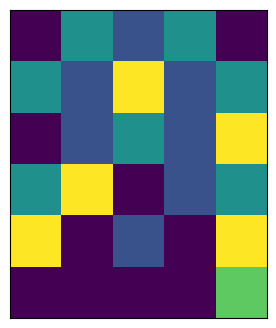

In [44]:
#Obtenemos la informacion en cada step y la graficamos para despues juntarla en una animacion
fig, axs=plt.subplots(figsize=(4,4))
axs.set_xticks([])
axs.set_yticks([])

if not all_grid.empty:
  print("hell yeah")
  patch = plt.imshow(all_grid.iloc[0][0], cmap='viridis')
else:
  print("no :C")
  patch = plt.imshow(np.zeros((model.grid.width, model.grid.height)), cmap='viridis')

def animate(i):
  if i < len(all_grid):
    patch.set_data(all_grid.iloc[i][0])
  else:
    patch.set_data(all_grid.iloc[-1][0])  # Muestra el último estado disponible

anim = animation.FuncAnimation(fig, animate, frames=MAX_ITER, repeat=False)
plt.show()

#Azul ossuro tirando a morado: Obstaculos
#Azul turquesa (Azul claro): Basura
# Verde. Papelera
# Morado: Celda vacia
#Amarillo: Agente robot

In [45]:
#Llamamos la animacion
anim